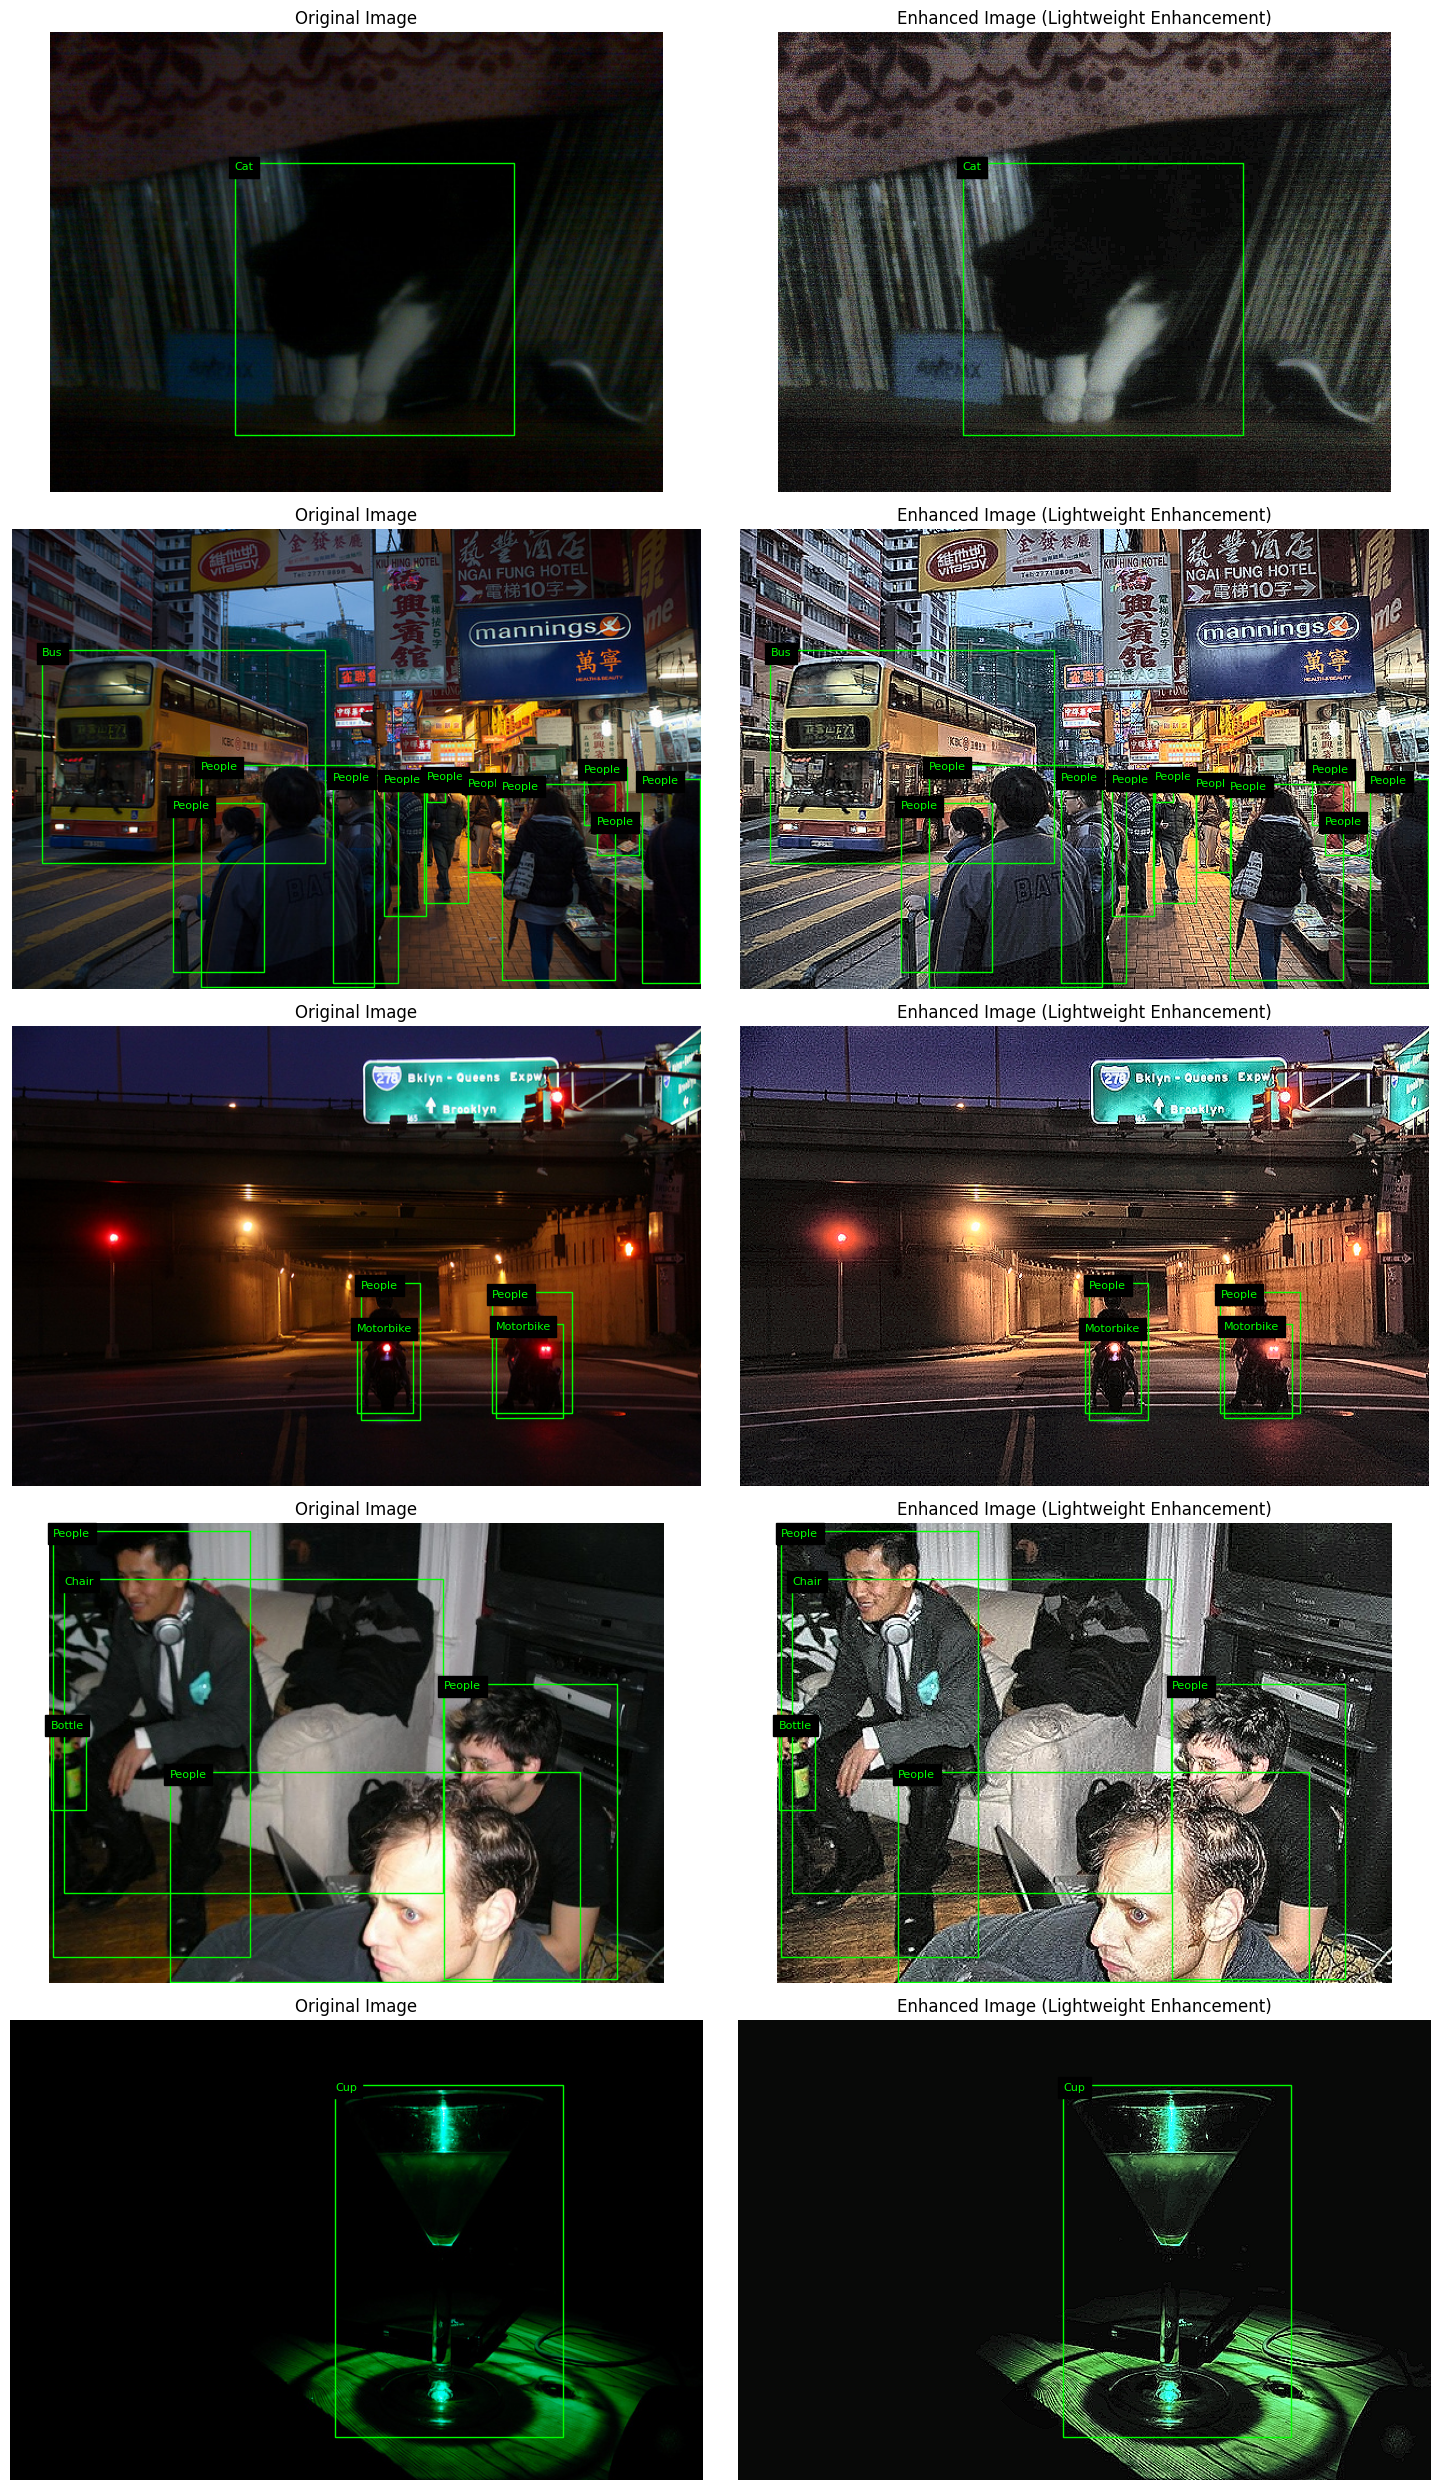

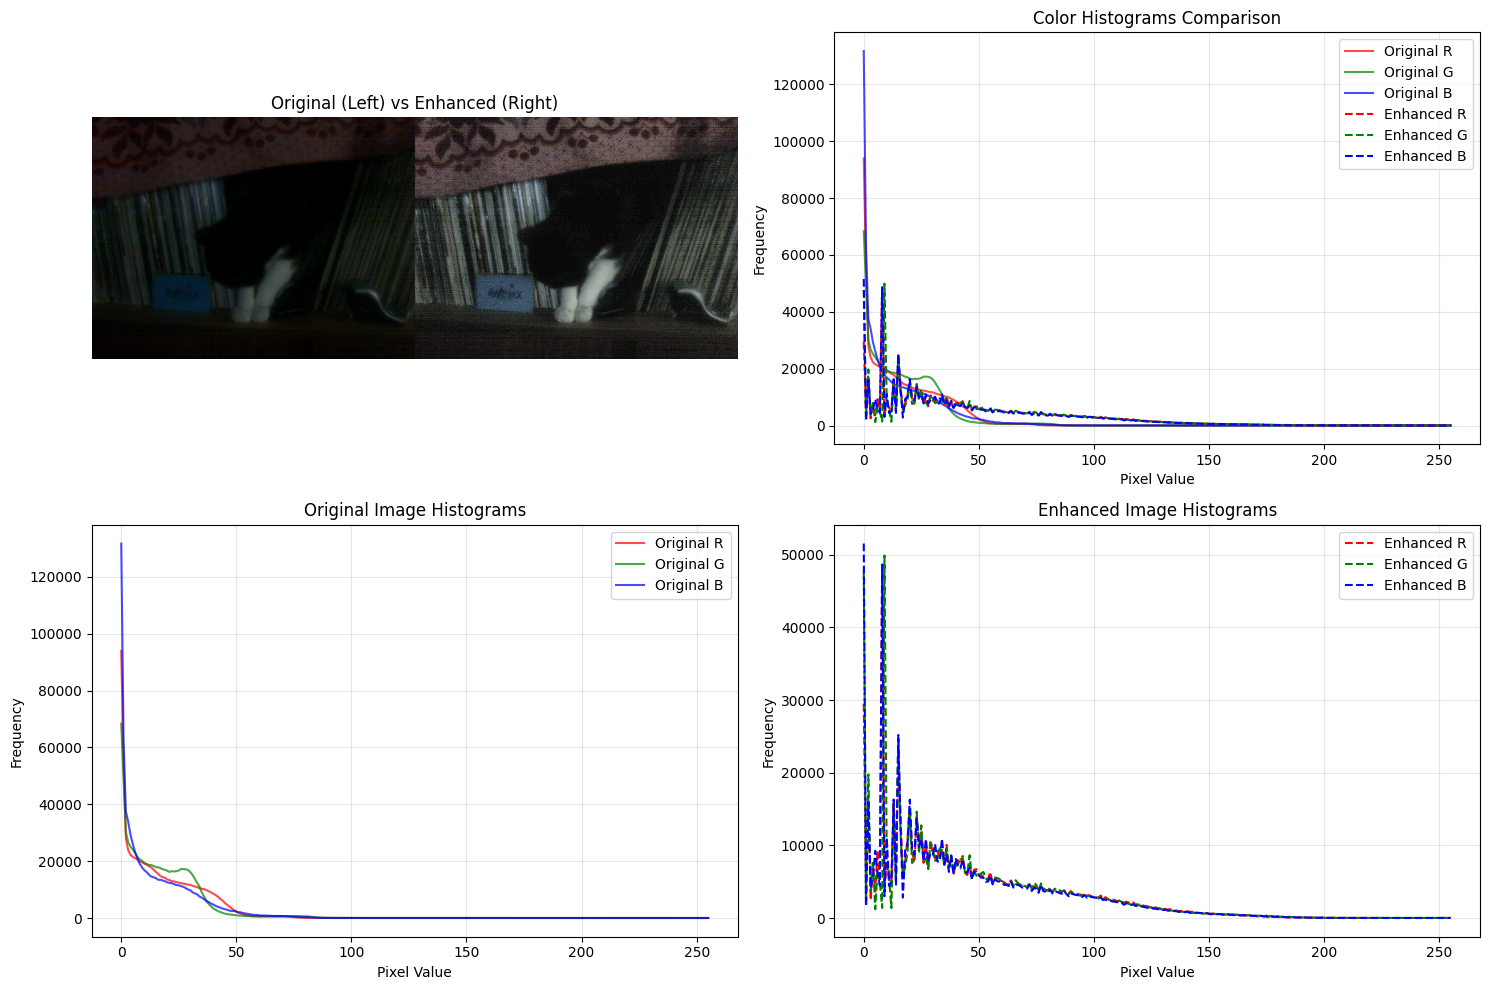

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from skimage.exposure import match_histograms

def multi_scale_histogram_fusion(image, scales=[0.75, 1.0, 1.25]):
    """
    Apply multi-scale histogram fusion to enhance image contrast and details
    
    Args:
        image: Input image (BGR format)
        scales: List of scales to use for multi-scale processing
        
    Returns:
        Enhanced image
    """
    # Convert to LAB color space for better color preservation
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Process at multiple scales
    fused_l = np.zeros_like(l, dtype=np.float32)
    weights = np.zeros_like(l, dtype=np.float32)
    
    for scale in scales:
        # Resize the image
        if scale != 1.0:
            new_size = (int(l.shape[1] * scale), int(l.shape[0] * scale))
            resized_l = cv2.resize(l, new_size, interpolation=cv2.INTER_CUBIC)
            resized_l = cv2.resize(resized_l, (l.shape[1], l.shape[0]), interpolation=cv2.INTER_CUBIC)
        else:
            resized_l = l.copy()
        
        # Apply CLAHE for local contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_l = clahe.apply(resized_l)
        
        # Calculate weight based on local contrast
        local_contrast = cv2.Laplacian(enhanced_l, cv2.CV_32F)
        weight = cv2.GaussianBlur(np.abs(local_contrast), (15, 15), 5)
        
        # Accumulate weighted sum
        fused_l += enhanced_l.astype(np.float32) * weight
        weights += weight
    
    # Normalize and convert back to uint8
    fused_l = np.clip(fused_l / (weights + 1e-7), 0, 255).astype(np.uint8)
    
    # Merge channels and convert back to BGR
    enhanced_lab = cv2.merge([fused_l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    
    return enhanced_image

# Paths
dataset_path = "/kaggle/input/object-detection-exdark/ExDark"
annot_path = "/kaggle/input/object-detection-exdark/ExDark_Annno"

# Get all image paths
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Select random images
random.seed(42)
selected_images = random.sample(image_paths, 5)

# Visualization
fig, axes = plt.subplots(nrows=len(selected_images), ncols=2, figsize=(15, 5*len(selected_images)))
if len(selected_images) == 1: 
    axes = [axes]  # Handle single image case

for i, (img_path) in enumerate(selected_images):
    # Read image
    image = cv2.imread(img_path)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply multi-scale histogram fusion
    enhanced_image = multi_scale_histogram_fusion(image)
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)
    
    # Build annotation path
    rel_path = os.path.relpath(img_path, dataset_path)
    annot_file_path = os.path.join(annot_path, rel_path + ".txt")
    
    # Check annotation existence
    if not os.path.exists(annot_file_path):
        print(f"Annotation {annot_file_path} not found - skipping")
        continue
    
    # Parse annotations
    boxes = []
    labels = []
    with open(annot_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('%') or not line: 
                continue
            parts = line.split()
            class_name = parts[0]
            x, y, w, h = map(int, parts[1:5])
            boxes.append((x, y, w, h))
            labels.append(class_name)
    
    # Draw original image with annotations
    ax_original = axes[i][0] if len(selected_images) > 1 else axes[0]
    ax_original.imshow(original_image)
    for (x, y, w, h), label in zip(boxes, labels):
        rect = patches.Rectangle((x, y), w, h, linewidth=1, 
                               edgecolor='lime', facecolor='none')
        ax_original.add_patch(rect)
        ax_original.text(x, y-2, label, color='lime', 
                       fontsize=8, va='top', backgroundcolor='black')
    ax_original.set_title('Original Image')
    ax_original.axis('off')
    
    # Draw enhanced image with annotations
    ax_enhanced = axes[i][1] if len(selected_images) > 1 else axes[1]
    ax_enhanced.imshow(enhanced_image_rgb)
    for (x, y, w, h), label in zip(boxes, labels):
        rect = patches.Rectangle((x, y), w, h, linewidth=1, 
                               edgecolor='lime', facecolor='none')
        ax_enhanced.add_patch(rect)
        ax_enhanced.text(x, y-2, label, color='lime', 
                       fontsize=8, va='top', backgroundcolor='black')
    ax_enhanced.set_title('Enhanced Image (Multi-Scale Histogram Fusion)')
    ax_enhanced.axis('off')

plt.tight_layout()
plt.savefig('enhanced_images_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Display a comparison of histograms for the first image
if len(selected_images) > 0:
    img_path = selected_images[0]
    image = cv2.imread(img_path)
    enhanced_image = multi_scale_histogram_fusion(image)
    
    # Convert to RGB for display
    original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    enhanced_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)
    
    # Calculate histograms
    original_hist_r = cv2.calcHist([original_rgb], [0], None, [256], [0, 256])
    original_hist_g = cv2.calcHist([original_rgb], [1], None, [256], [0, 256])
    original_hist_b = cv2.calcHist([original_rgb], [2], None, [256], [0, 256])
    
    enhanced_hist_r = cv2.calcHist([enhanced_rgb], [0], None, [256], [0, 256])
    enhanced_hist_g = cv2.calcHist([enhanced_rgb], [1], None, [256], [0, 256])
    enhanced_hist_b = cv2.calcHist([enhanced_rgb], [2], None, [256], [0, 256])
    
    # Plot histograms
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(np.hstack([original_rgb, enhanced_rgb]))
    plt.title('Original (Left) vs Enhanced (Right)')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.plot(original_hist_r, color='r', alpha=0.7, label='Original R')
    plt.plot(original_hist_g, color='g', alpha=0.7, label='Original G')
    plt.plot(original_hist_b, color='b', alpha=0.7, label='Original B')
    plt.plot(enhanced_hist_r, color='r', linestyle='--', label='Enhanced R')
    plt.plot(enhanced_hist_g, color='g', linestyle='--', label='Enhanced G')
    plt.plot(enhanced_hist_b, color='b', linestyle='--', label='Enhanced B')
    plt.title('Color Histograms Comparison')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.plot(original_hist_r, color='r', alpha=0.7, label='Original R')
    plt.plot(original_hist_g, color='g', alpha=0.7, label='Original G')
    plt.plot(original_hist_b, color='b', alpha=0.7, label='Original B')
    plt.title('Original Image Histograms')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.plot(enhanced_hist_r, color='r', linestyle='--', label='Enhanced R')
    plt.plot(enhanced_hist_g, color='g', linestyle='--', label='Enhanced G')
    plt.plot(enhanced_hist_b, color='b', linestyle='--', label='Enhanced B')
    plt.title('Enhanced Image Histograms')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('histogram_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [15]:
import os
import cv2
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torch.cuda import amp  # Mixed precision

In [ ]:
# Multi-Scale Histogram Fusion Function
def multi_scale_histogram_fusion(image, scales=[0.75, 1.0, 1.25]):
    """
    Apply multi-scale histogram fusion to enhance image contrast and details
    
    Args:
        image: Input image (BGR format)
        scales: List of scales to use for multi-scale processing
        
    Returns:
        Enhanced image
    """
    # Convert to LAB color space for better color preservation
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Process at multiple scales
    fused_l = np.zeros_like(l, dtype=np.float32)
    weights = np.zeros_like(l, dtype=np.float32)
    
    for scale in scales:
        # Resize the image
        if scale != 1.0:
            new_size = (int(l.shape[1] * scale), int(l.shape[0] * scale))
            resized_l = cv2.resize(l, new_size, interpolation=cv2.INTER_CUBIC)
            resized_l = cv2.resize(resized_l, (l.shape[1], l.shape[0]), interpolation=cv2.INTER_CUBIC)
        else:
            resized_l = l.copy()
        
        # Apply CLAHE for local contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_l = clahe.apply(resized_l)
        
        # Calculate weight based on local contrast
        local_contrast = cv2.Laplacian(enhanced_l, cv2.CV_32F)
        weight = cv2.GaussianBlur(np.abs(local_contrast), (15, 15), 5)
        
        # Accumulate weighted sum
        fused_l += enhanced_l.astype(np.float32) * weight
        weights += weight
    
    # Normalize and convert back to uint8
    fused_l = np.clip(fused_l / (weights + 1e-7), 0, 255).astype(np.uint8)
    
    # Merge channels and convert back to BGR
    enhanced_lab = cv2.merge([fused_l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    
    return enhanced_image

In [16]:
# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.005
IMG_SIZE = 224
CLASSES = ['Bicycle', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 
          'Chair', 'Cup', 'Dog', 'Motorbike', 'People', 'Table']
NUM_CLASSES = len(CLASSES) + 1
DATASET_PATH = "/kaggle/input/object-detection-exdark/ExDark"
ANNOT_PATH = "/kaggle/input/object-detection-exdark/ExDark_Annno"

In [19]:
# Custom Dataset with Multi-Scale Histogram Fusion
class ExDarkDataset(Dataset):
    def __init__(self, root_dir, annot_dir, classes, transform=None, apply_enhancement=True):
        self.root_dir = root_dir
        self.annot_dir = annot_dir
        self.transform = transform
        self.apply_enhancement = apply_enhancement
        self.class_to_idx = {cls: i+1 for i, cls in enumerate(classes)}
        self.image_paths = []
        self.annotations = {}  # Cache annotations
        
        # Collect valid image paths and pre-load annotations
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(root, file)
                    annot_path = self._get_annot_path(img_path)
                    if os.path.exists(annot_path):
                        with open(annot_path, 'r') as f:
                            lines = [line.strip() for line in f 
                                     if line.strip() and not line.startswith('%')]
                        if lines:
                            self.image_paths.append(img_path)
                            self.annotations[img_path] = lines

    def _get_annot_path(self, img_path):
        rel_path = os.path.relpath(img_path, self.root_dir)
        return os.path.join(self.annot_dir, rel_path + ".txt")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        
        # Apply multi-scale histogram fusion if enabled
        if self.apply_enhancement:
            image = multi_scale_histogram_fusion(image)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Resize image
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        scale_x, scale_y = IMG_SIZE/w, IMG_SIZE/h
        
        boxes = []
        labels = []
        
        for line in self.annotations[img_path]:
            parts = line.split()
            class_name = parts[0]
            x, y, w_box, h_box = map(int, parts[1:5])
            
            # Scale bounding boxes
            xmin = max(0, min(w-1, x)) * scale_x
            ymin = max(0, min(h-1, y)) * scale_y
            xmax = max(0, min(w, x + w_box)) * scale_x
            ymax = max(0, min(h, y + h_box)) * scale_y
            
            # Skip invalid boxes
            if (xmax - xmin) < 1 or (ymax - ymin) < 1:
                continue
                
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_to_idx[class_name])
        
        if len(boxes) == 0:
            return self[(idx + 1) % len(self)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Normalize image
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        image = torchvision.transforms.functional.normalize(
            image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return image, {'boxes': boxes, 'labels': labels}

In [21]:
# Model Architecture
def create_model():
    backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
    backbone.out_channels = 960
    
    # Adjusted anchor sizes for 224x224 input
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128, 256),),  # Smaller anchors
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    return FasterRCNN(
        backbone,
        num_classes=NUM_CLASSES,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

In [22]:
# Data Loading
def collate_fn(batch):
    return tuple(zip(*batch))

def create_datasets():
    # Create datasets with enhancement enabled
    full_dataset = ExDarkDataset(DATASET_PATH, ANNOT_PATH, CLASSES, apply_enhancement=True)
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    return torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_dataset, val_dataset, test_dataset = create_datasets()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

In [12]:
# Training Setup
model = create_model().to(DEVICE)
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = amp.GradScaler()  # Mixed precision

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 149MB/s]
/tmp/ipykernel_36/1729380206.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)

In [23]:
# Training and Evaluation
train_loss_history = []
val_loss_history = []
val_map_history = []
test_map_history = []
val_acc_history = []
test_acc_history = []
all_val_preds = []
all_val_targets = []
all_test_preds = []
all_test_targets = []

for epoch in range(NUM_EPOCHS):
    # Training with mixed precision
    model.train()
    epoch_train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Train Epoch {epoch+1}")
    for images, targets in train_bar:
        images = [img.to(DEVICE, non_blocking=True) for img in images]
        targets = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
        
        with torch.amp.autocast('cuda'):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_train_loss += losses.item()
        train_bar.set_postfix(loss=losses.item())
    
    train_loss = epoch_train_loss/len(train_loader)
    train_loss_history.append(train_loss)
    lr_scheduler.step()

    # Validation
    model.eval()
    metric = MeanAveragePrecision()
    preds_for_cm = []
    targets_for_cm = []
    correct = 0
    total = 0
    epoch_val_loss = 0
    val_batches = 0

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            images = [img.to(DEVICE, non_blocking=True) for img in images]
            targets_gpu = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
            
            # Compute validation loss
            model.train()
            with torch.amp.autocast('cuda'):
                loss_dict = model(images, targets_gpu)
                losses = sum(loss for loss in loss_dict.values())
                epoch_val_loss += losses.item()
                val_batches += 1
            model.eval()
            
            # Get predictions
            with torch.amp.autocast('cuda'):
                predictions = model(images)
            
            metric.update(predictions, targets_gpu)
            
            # Accuracy calculation
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                mask = pred['scores'] > 0.5
                pred_labels = pred['labels'][mask].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                
                min_len = min(len(pred_labels), len(true_labels))
                if min_len > 0:
                    matches = np.sum(pred_labels[:min_len] == true_labels[:min_len])
                    correct += matches
                    total += min_len
                
                if epoch == NUM_EPOCHS-1 and len(pred_labels) == len(true_labels) and len(pred_labels) > 0:
                    preds_for_cm.extend(pred_labels)
                    targets_for_cm.extend(true_labels)
    
    val_loss = epoch_val_loss / val_batches if val_batches > 0 else 0
    val_loss_history.append(val_loss)

    map_metrics = metric.compute()
    val_map = map_metrics['map'].item()
    val_map_history.append(val_map)
    val_acc = correct / total if total > 0 else 0
    val_acc_history.append(val_acc)
    
    if epoch == NUM_EPOCHS-1:
        all_val_preds = preds_for_cm
        all_val_targets = targets_for_cm

    # Testing
    metric_test = MeanAveragePrecision()
    preds_for_cm_test = []
    targets_for_cm_test = []
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc=f"Test Epoch {epoch+1}"):
            images = [img.to(DEVICE, non_blocking=True) for img in images]
            targets_gpu = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
            
            with torch.amp.autocast('cuda'):
                predictions = model(images)
            
            metric_test.update(predictions, targets_gpu)
            
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                mask = pred['scores'] > 0.5
                pred_labels = pred['labels'][mask].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                
                min_len = min(len(pred_labels), len(true_labels))
                if min_len > 0:
                    matches = np.sum(pred_labels[:min_len] == true_labels[:min_len])
                    correct_test += matches
                    total_test += min_len
                
                if epoch == NUM_EPOCHS-1 and len(pred_labels) == len(true_labels) and len(pred_labels) > 0:
                    preds_for_cm_test.extend(pred_labels)
                    targets_for_cm_test.extend(true_labels)
    
    map_metrics_test = metric_test.compute()
    test_map = map_metrics_test['map'].item()
    test_map_history.append(test_map)
    test_acc = correct_test / total_test if total_test > 0 else 0
    test_acc_history.append(test_acc)
    
    if epoch == NUM_EPOCHS-1:
        all_test_preds = preds_for_cm_test
        all_test_targets = targets_for_cm_test

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mAP: {val_map:.4f} | Test mAP: {test_map:.4f}")
    print(f"Validation Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}\n")


/tmp/ipykernel_36/2390458038.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # Mixed precision
Train Epoch 1:  89%|████████▉ | 572/644 [04:26<00:33,  2.18it/s, loss=0.429]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 1:  61%|██████    | 84/138 [00:20<00:12,  4.30it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 1:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_36/2390458038.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Test Epoch 1: 100%|██████████| 139/139 [00:13<00:00,  9.96it/s]



Epoch 1/10
Train Loss: 0.6247 | Val Loss: 0.5427 | Val mAP: 0.0269 | Test mAP: 0.0263
Validation Acc: 0.6000 | Test Acc: 0.6667



Train Epoch 2:  79%|███████▉  | 509/644 [03:55<01:01,  2.19it/s, loss=0.415]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 2:  61%|██████    | 84/138 [00:20<00:13,  4.12it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 2: 100%|██████████| 139/139 [00:15<00:00,  9.20it/s]



Epoch 2/10
Train Loss: 0.5204 | Val Loss: 0.5116 | Val mAP: 0.0733 | Test mAP: 0.0688
Validation Acc: 0.5707 | Test Acc: 0.5840



Train Epoch 3:  36%|███▌      | 230/644 [01:46<03:12,  2.15it/s, loss=0.512]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 3:  61%|██████    | 84/138 [00:21<00:13,  4.08it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 3: 100%|██████████| 139/139 [00:15<00:00,  9.14it/s]



Epoch 3/10
Train Loss: 0.4832 | Val Loss: 0.5005 | Val mAP: 0.1057 | Test mAP: 0.1012
Validation Acc: 0.5870 | Test Acc: 0.5892



Train Epoch 4:   2%|▏         | 11/644 [00:05<04:55,  2.14it/s, loss=0.719]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 4:  61%|██████    | 84/138 [00:20<00:13,  4.13it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 4: 100%|██████████| 139/139 [00:15<00:00,  9.15it/s]



Epoch 4/10
Train Loss: 0.4473 | Val Loss: 0.4892 | Val mAP: 0.1248 | Test mAP: 0.1207
Validation Acc: 0.6129 | Test Acc: 0.6127



Train Epoch 5:  34%|███▍      | 219/644 [01:42<03:15,  2.17it/s, loss=0.388]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 5:  61%|██████    | 84/138 [00:21<00:13,  4.02it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 5: 100%|██████████| 139/139 [00:15<00:00,  9.01it/s]



Epoch 5/10
Train Loss: 0.4466 | Val Loss: 0.4948 | Val mAP: 0.1292 | Test mAP: 0.1264
Validation Acc: 0.6127 | Test Acc: 0.6124



Train Epoch 6:  63%|██████▎   | 408/644 [03:09<01:48,  2.18it/s, loss=0.531]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 6:  61%|██████    | 84/138 [00:21<00:13,  4.11it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 6: 100%|██████████| 139/139 [00:15<00:00,  9.04it/s]



Epoch 6/10
Train Loss: 0.4451 | Val Loss: 0.4919 | Val mAP: 0.1312 | Test mAP: 0.1293
Validation Acc: 0.6162 | Test Acc: 0.6173



Train Epoch 7:  25%|██▍       | 158/644 [01:13<03:39,  2.22it/s, loss=0.39] libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 7:  61%|██████    | 84/138 [00:20<00:13,  4.08it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 7: 100%|██████████| 139/139 [00:15<00:00,  9.10it/s]



Epoch 7/10
Train Loss: 0.4413 | Val Loss: 0.4887 | Val mAP: 0.1323 | Test mAP: 0.1297
Validation Acc: 0.6178 | Test Acc: 0.6105



Train Epoch 8:  45%|████▍     | 287/644 [02:13<02:45,  2.15it/s, loss=0.359]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 8:  61%|██████    | 84/138 [00:21<00:13,  4.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 8: 100%|██████████| 139/139 [00:15<00:00,  9.08it/s]



Epoch 8/10
Train Loss: 0.4401 | Val Loss: 0.4894 | Val mAP: 0.1335 | Test mAP: 0.1299
Validation Acc: 0.6179 | Test Acc: 0.6042



Train Epoch 9:  76%|███████▋  | 492/644 [03:46<01:09,  2.17it/s, loss=0.631]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 9:  61%|██████    | 84/138 [00:20<00:12,  4.16it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 9: 100%|██████████| 139/139 [00:15<00:00,  9.11it/s]



Epoch 9/10
Train Loss: 0.4417 | Val Loss: 0.4897 | Val mAP: 0.1346 | Test mAP: 0.1310
Validation Acc: 0.6211 | Test Acc: 0.6114



Train Epoch 10:  23%|██▎       | 147/644 [01:08<03:48,  2.17it/s, loss=0.263]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 10:  61%|██████    | 84/138 [00:20<00:13,  4.15it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 10: 100%|██████████| 139/139 [00:15<00:00,  9.09it/s]



Epoch 10/10
Train Loss: 0.4399 | Val Loss: 0.4882 | Val mAP: 0.1342 | Test mAP: 0.1330
Validation Acc: 0.6154 | Test Acc: 0.6056



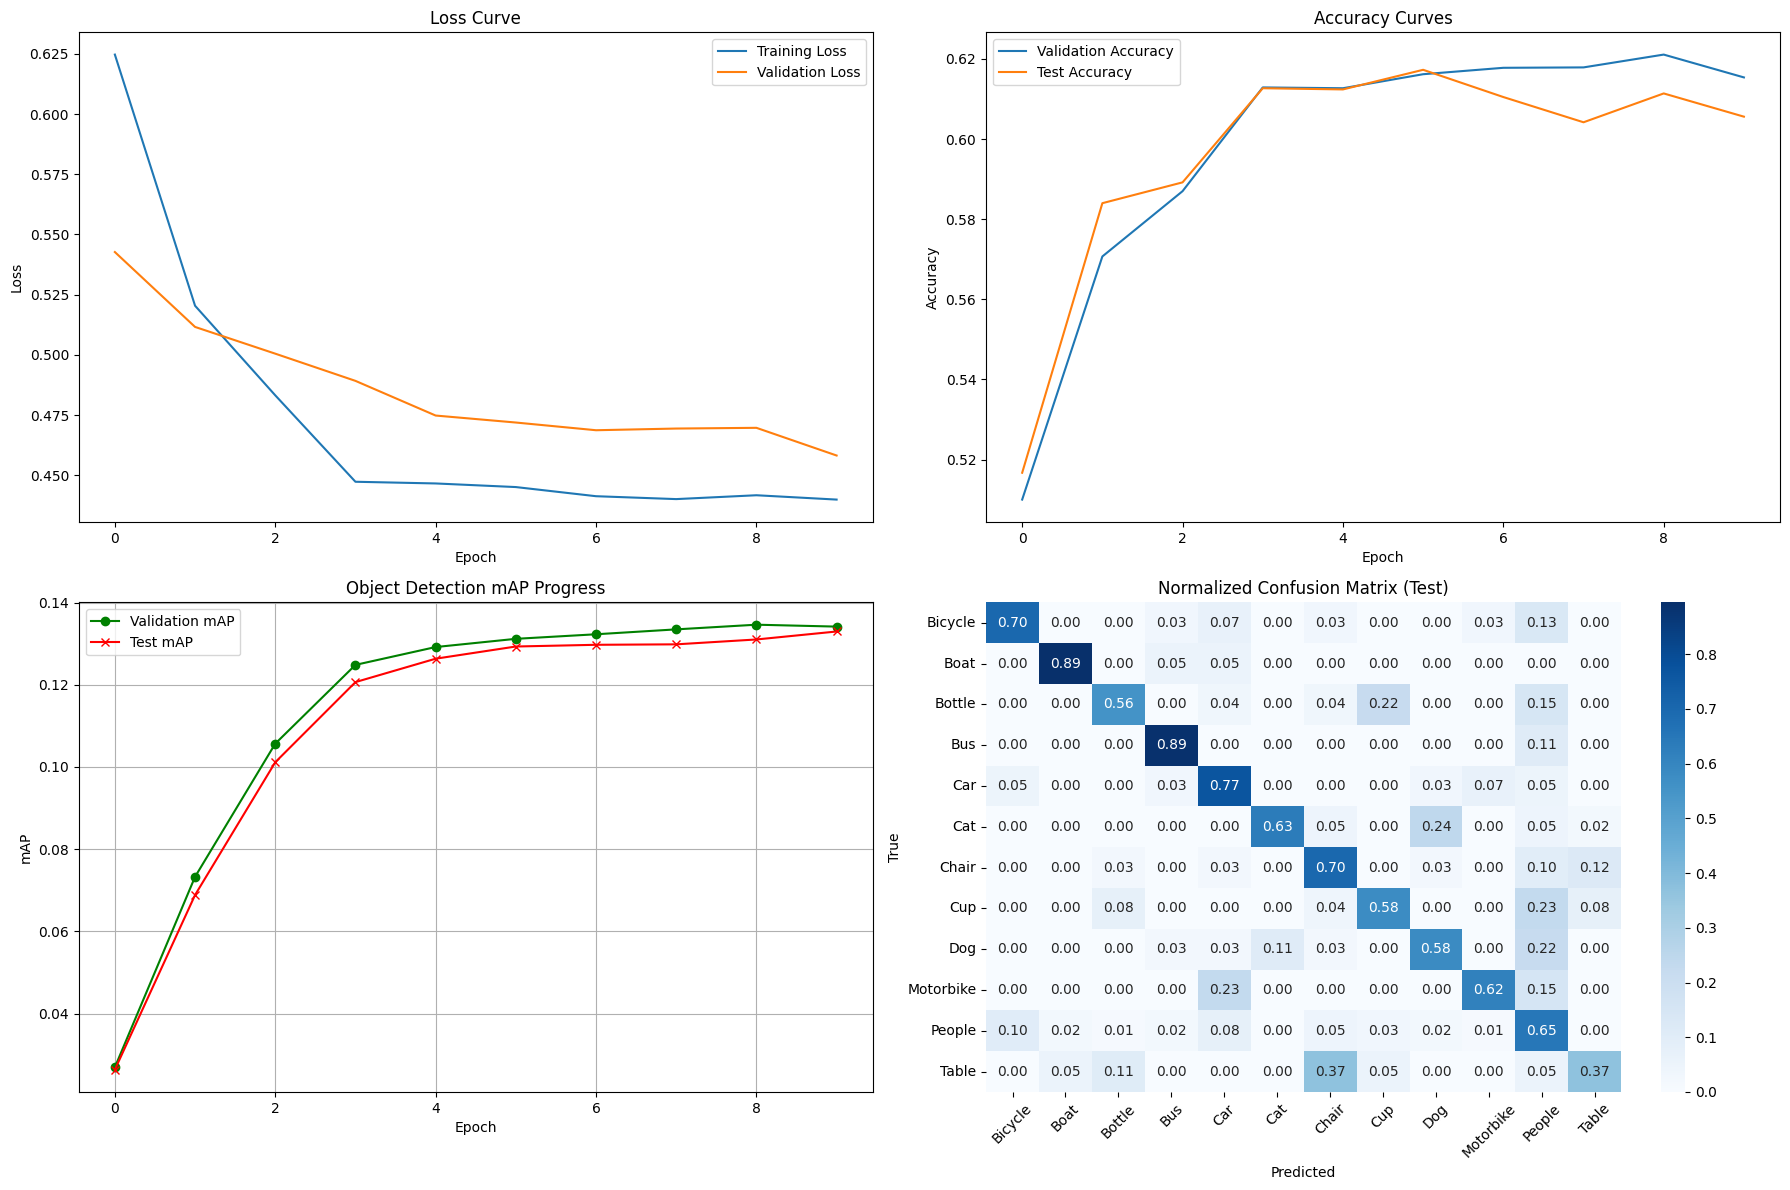

In [34]:
# Visualization (MODIFIED)
plt.figure(figsize=(18, 12))

# Loss Curve (train and validation)
plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curves
plt.subplot(2, 2, 2)
plt.plot(val_acc_history, label='Validation Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# mAP Curve
plt.subplot(2, 2, 3)
plt.plot(val_map_history, color='green', marker='o', label='Validation mAP')
plt.plot(test_map_history, color='red', marker='x', label='Test mAP')
plt.title('Object Detection mAP Progress')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)

# Confusion Matrix (Test)
plt.subplot(2, 2, 4)
cm = confusion_matrix(all_test_targets, all_test_preds, labels=range(1, NUM_CLASSES))
row_sums = cm.sum(axis=1, keepdims=True)
cm = np.divide(cm.astype('float'), row_sums, where=row_sums != 0)
cm = np.nan_to_num(cm)

sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Normalized Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()
plt.close()

In [26]:
# Classification Report (Test)
report = classification_report(
    all_test_targets, all_test_preds,
    target_names=CLASSES,
    labels=range(1, NUM_CLASSES),
    digits=4
)
print("\nClassification Report (Test):")
print(report)


Classification Report (Test):
              precision    recall  f1-score   support

     Bicycle     0.6364    0.7000    0.6667        30
        Boat     0.8500    0.8947    0.8718        19
      Bottle     0.7143    0.5556    0.6250        27
         Bus     0.6957    0.8889    0.7805        18
         Car     0.7419    0.7667    0.7541        60
         Cat     0.8667    0.6341    0.7324        41
       Chair     0.6222    0.7000    0.6588        40
         Cup     0.6000    0.5769    0.5882        26
         Dog     0.5833    0.5833    0.5833        36
   Motorbike     0.5714    0.6154    0.5926        13
      People     0.6129    0.6477    0.6298        88
       Table     0.4667    0.3684    0.4118        19

    accuracy                         0.6643       417
   macro avg     0.6635    0.6610    0.6579       417
weighted avg     0.6686    0.6643    0.6627       417



In [25]:
# Detailed Metrics (Test)
metrics_str = "\nDetailed Test Metrics:\n"
for key, value in map_metrics_test.items():
    if isinstance(value, torch.Tensor):
        if value.numel() == 1:
            metrics_str += f"{key:20}: {value.item():.4f}\n"
        else:
            metrics_str += f"{key:20}: {[round(v.item(), 4) for v in value]}\n"
print(metrics_str)



Detailed Test Metrics:
map                 : 0.1330
map_50              : 0.3241
map_75              : 0.0829
map_small           : 0.0224
map_medium          : 0.1474
map_large           : 0.2684
mar_1               : 0.1801
mar_10              : 0.2787
mar_100             : 0.2928
mar_small           : 0.0882
mar_medium          : 0.3401
mar_large           : 0.4808
map_per_class       : -1.0000
mar_100_per_class   : -1.0000
classes             : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]



In [13]:
# Save Model
torch.save(model.state_dict(), 'detection_model_02.pth')
print("Training complete! Model saved.")

Training complete! Model saved.
